In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

datos = pd.read_csv("/content/drive/MyDrive/Tecmilenio/Hackaton/pokemon.csv")
datos.head(n = 5) # Nombres de las columnas y primeros 5 registros

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [3]:
datos.info() # Información sobre los datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

Podemos apreciar que hay 40 columnas, de las cuales la mayoría están completas.

Hay dos columnas, `height_m` y `weight_m`, que contienen datos vacíos en 20 filas. Según una pregunta en el [foro de discusión de este dataset](https://www.kaggle.com/datasets/rounakbanik/pokemon/discussion/115718) en Kaggle, esto se debe principalmente a las múltiples formas de algunos Pokémon, la inclusión de estadísticas de formas alternas y algunas peculiaridades en los datos de captura. La mayoría de estos Pokémon pertenecen a la primera generación. Decidí eliminar esas columnas para este modelo.

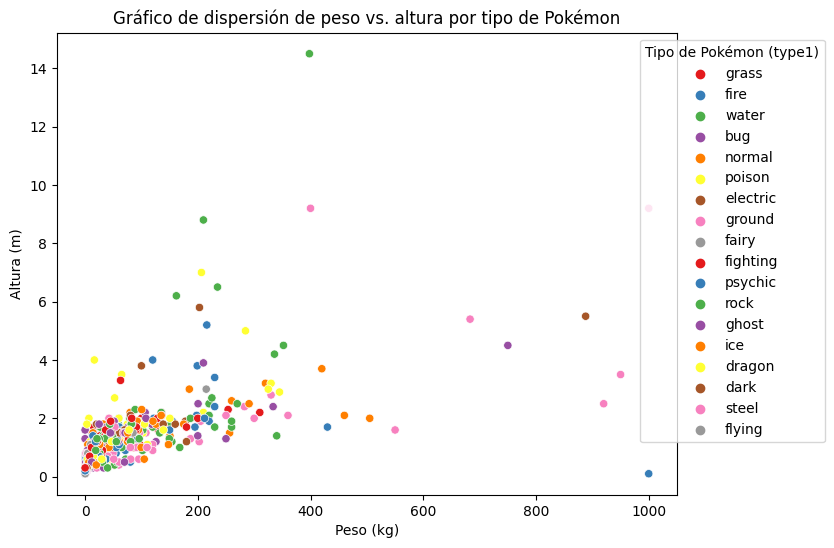

In [4]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=datos, x='weight_kg', y='height_m', hue='type1', palette='Set1')
plt.title('Gráfico de dispersión de peso vs. altura por tipo de Pokémon')
plt.xlabel('Peso (kg)')
plt.ylabel('Altura (m)')
plt.legend(title='Tipo de Pokémon (type1)', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

Se descartará la columna `type2`, ya que esta solamente contendrá un dato si se trata de un Pokémon de dos tipos, y este modelo no clasificará combinaciones sino los tipos únicos.
<br><br>

Hay otra columna que llama la atención por los datos faltantes, y es `percentage_male`. Esta indica el porcentaje de la especie que es masculino. Los valores en blanco indican que el Pokémon no tiene género.
Para hacer esto más computable decidí transformarlos en una función que hiciera una estimación de su género.
<br><img src="https://gcdnb.pbrd.co/images/D0yzgRb83TVy.png" width="500px">

In [5]:
import math

def gender_encode(percentage_male):
    if math.isnan(percentage_male):
        return 0 # Pokémon sin género
    else:
        return (percentage_male - 50) / 50 # Valores en el rango [-1, 1]

#datos['percentage_male_encoded'] = datos['percentage_male'].apply(gender_encode)
#datos.loc[:,['name', 'percentage_male_encoded']].sample(n=10) # Muestra aleatoria de 10 Pokémon para comprobar que se aplicó correctamente este cambio.

Ahora, eliminamos otras de las columnas que no son indispensables, que no contienen valores numéricos, las cuales son:
* `abilities`: un arreglo de cadenas de texto que contiene nombres de habilidades
* `classfication`: cadena de texto que contiene el nombre de cómo se clasifica ese Pokémon
* `japanese_name`: nombre del Pokémon en japonés
* `name`: nombre del Pokémon
* `pokedex_number`: aunque sí es un dato numérico, no es precisamente influyente en el modelo, y podría afectar la presición.
* `is_legendary`: este valor es un booleano (0 y 1), podría afectar los cálculos al considerarse junto con el resto de valores numéricos.

También, hay un Pokémon que en su taza de captura (`capture_rate`) contiene datos no numéricos. Ya que solo es uno, lo eliminaré. Y ya que en la columna no quedan más datos no numéricos, convierto la columna a tipo float.

In [6]:
datos_clean = datos.drop(datos[datos['pokedex_number'] == 774].index) # Elimino el Pokémon 774 (índice de Pokedex, no del dataset), ya que no tiene el parámetro inplace, se crea un nuevo dataframe.

datos_clean.drop(['height_m', 'weight_kg', 'percentage_male', 'abilities', 'classfication', 'japanese_name', 'name', 'pokedex_number', 'type2', 'is_legendary'], axis=1, inplace=True) # Elimino las columnas

datos_clean['capture_rate'] = datos_clean['capture_rate'].astype(float) # Convierto la columna capture_rate en float
datos_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   against_bug        800 non-null    float64
 1   against_dark       800 non-null    float64
 2   against_dragon     800 non-null    float64
 3   against_electric   800 non-null    float64
 4   against_fairy      800 non-null    float64
 5   against_fight      800 non-null    float64
 6   against_fire       800 non-null    float64
 7   against_flying     800 non-null    float64
 8   against_ghost      800 non-null    float64
 9   against_grass      800 non-null    float64
 10  against_ground     800 non-null    float64
 11  against_ice        800 non-null    float64
 12  against_normal     800 non-null    float64
 13  against_poison     800 non-null    float64
 14  against_psychic    800 non-null    float64
 15  against_rock       800 non-null    float64
 16  against_steel      800 non

In [7]:
# ¿Cuántos tipos de Pokémon hay (type1)?
datos_clean['type1'].nunique()

18

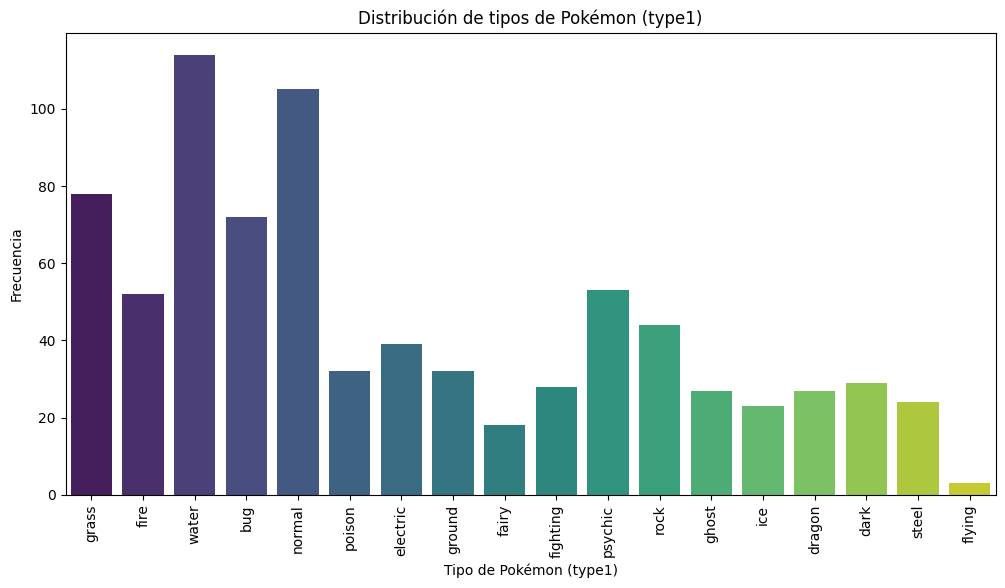

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=datos_clean, x='type1', palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribución de tipos de Pokémon (type1)')
plt.xlabel('Tipo de Pokémon (type1)')
plt.ylabel('Frecuencia')
plt.show()

Ahora que el dataset ya está prácticamente completo, podemos pasar al modelo haciendo uso de las herramientas de modelado de [sklearn](https://scikit-learn.org/stable/).

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

X = datos_clean.drop('type1', axis=1)
y = datos_clean['type1']

# Definir la función para encontrar la mejor semilla y calcular el promedio de precisión
def find_best_seed(X, y):
    accuracies = []
    best_seed = None
    best_accuracy = 0

    for seed in range(1, 101):  # Prueba semillas del 1 al 100
        # Dividir los datos en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # Crear y entrenar el modelo
        model = RandomForestClassifier(random_state=seed)
        model.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba
        y_pred = model.predict(X_test)

        # Calcular la precisión del modelo
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Actualizar la mejor semilla si se encuentra una mejor precisión
        if accuracy > best_accuracy:
            best_seed = seed
            best_accuracy = accuracy

    # Calcular el promedio de las precisiones
    average_accuracy = np.mean(accuracies)

    # Generar el informe completo con métricas
    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size=0.2, random_state=best_seed)
    final_model = RandomForestClassifier(random_state=best_seed)
    final_model.fit(X_train_final, y_train_final)
    y_pred_final = final_model.predict(X_test_final)
    full_report = classification_report(y_test_final, y_pred_final, zero_division=1)

    return best_seed, best_accuracy, average_accuracy, full_report

# Llamar a la función con tus datos (X, y)
best_seed, best_precision, average_precision, full_report = find_best_seed(X, y)

# Imprimir resultados
print(f"Mejor semilla: {best_seed}")
print(f"Precisión en la mejor semilla: {best_precision:.2f}")
print(f"Precisión promedio: {average_precision:.2f}")
print(f"Informe completo:\n{full_report}")

Mejor semilla: 97
Precisión en la mejor semilla: 0.96
Precisión promedio: 0.92
Informe completo:
              precision    recall  f1-score   support

         bug       1.00      1.00      1.00        15
        dark       0.75      1.00      0.86         3
      dragon       0.83      1.00      0.91         5
    electric       1.00      1.00      1.00         8
       fairy       1.00      1.00      1.00         3
    fighting       1.00      1.00      1.00         6
        fire       1.00      0.86      0.92         7
       ghost       1.00      1.00      1.00         5
       grass       0.96      1.00      0.98        22
      ground       1.00      1.00      1.00         4
         ice       1.00      0.71      0.83         7
      normal       1.00      0.95      0.98        21
      poison       1.00      0.83      0.91         6
     psychic       1.00      1.00      1.00        12
        rock       0.83      1.00      0.91         5
       steel       1.00      1.00     